In [1]:
!pip install --upgrade pip
!pip install keras numpy opencv-python matplotlib seaborn scikit-learn scipy matplotlib pydot pydotplus graphviz scikit-image

In [18]:
import seaborn as sns
import cv2
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet101
from keras.applications.vgg19 import preprocess_input

## Data Preparation

This dataset comes from [kaggle](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

To prepare our data for the model, we have to tranform it in two steps:
1. Get the data in a dataframe with these columns
2. Crop Original image and create a dataframe

In [19]:
# Let's create paths
images_paths = []
annotations_paths = []

for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path[-3:] == 'xml':
            annotations_paths.append(file_path)
        elif file_path[-3:] == 'png':
            images_paths.append(file_path)
            
print("Loaded all images" if len(images_paths) == 853 else "Oops...")

Loaded all images


In [20]:
import xml.etree.ElementTree as ET

# First dataframe
df = pd.DataFrame(columns=['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

for xml_file in annotations_paths:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    file_name = root.find('filename').text
#     foreach object
    for obj in root.findall('object'):
        row = {
            'file_name': file_name,
            'label': obj.find('name').text,
            'xmin': int(obj.find('bndbox').find('xmin').text),
            'ymin': int(obj.find('bndbox').find('ymin').text),
            'xmax': int(obj.find('bndbox').find('xmax').text),
            'ymax': int(obj.find('bndbox').find('ymax').text)
        }
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        
print(df)
print(df.label.value_counts())

                file_name                  label xmin ymin xmax ymax
0     maksssksksss299.png           without_mask   62  194  160  320
1     maksssksksss528.png           without_mask   43  169  149  308
2     maksssksksss272.png  mask_weared_incorrect   48  107  218  304
3     maksssksksss514.png              with_mask   28   78   43   99
4     maksssksksss514.png              with_mask  160   66  176   83
...                   ...                    ...  ...  ...  ...  ...
4067  maksssksksss294.png           without_mask  271   73  278   82
4068  maksssksksss294.png           without_mask  236   91  243   99
4069  maksssksksss294.png           without_mask  236   76  243   83
4070  maksssksksss294.png              with_mask  264   76  268   82
4071  maksssksksss294.png              with_mask  281   72  286   78

[4072 rows x 6 columns]
label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

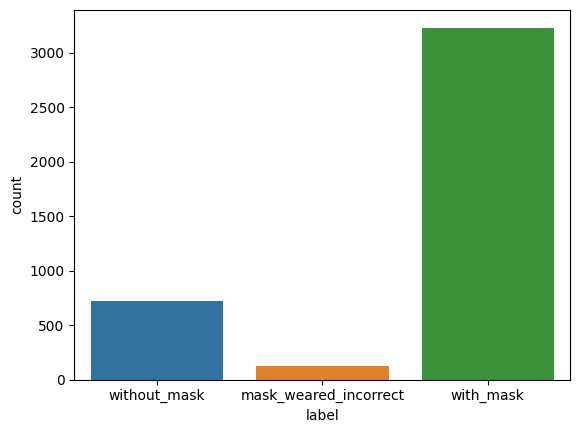

In [21]:
sns.countplot(x=df.label)

### Image Cropping

We crop the images before we feed them to the CNNs

In [22]:
BASE_DIR_IMG = './input/images/'
def crop_image(file, xmin, ymin, xmax, ymax, is_im_arr=False):
    if is_im_arr is False:
        im = Image.open(BASE_DIR_IMG + file)
        im_arr = np.array(im)
    else:
        im_arr = np.array(file)
    # cropping
    im_cropped = im_arr[ymin:ymax, xmin:xmax, :3]
    return im_cropped

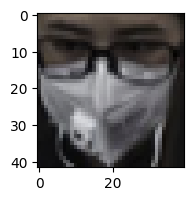

In [23]:
# Test our crop_image function
row = df.iloc[200]
im_cropped = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
# plot image cropped
plt.figure(figsize=(2,2))
plt.imshow(im_cropped)
plt.show()

### Image Resizing

We need to make sure all images are correctly sized (224, 224) to be fed to the models

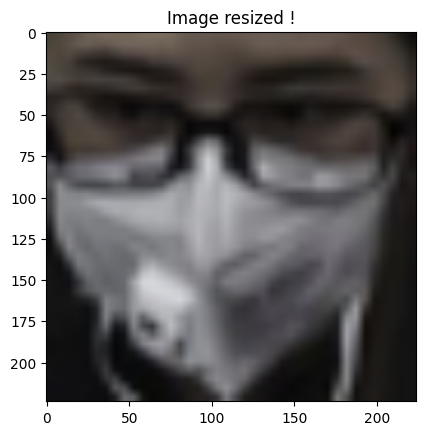

In [24]:
plt.imshow(cv2.resize(im_cropped, (224, 224)))
plt.title("Image resized !")
plt.show()

In [25]:
# We create the 3 datasets and iterate to transform file_path to cropped image
def create_data_batch(X, y=None, batch_size=32, valid_data=False, test_data=False):
    if test_data:
        print('Creating test dataset')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.batch(batch_size)
    elif valid_data:
        print('Creating valid dataset')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.batch(batch_size)
    else:
        print('Creating Training dataset')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.batch(batch_size)
    return data_batch

Run for the whole dataframe - we should have 4072 faces in the 853 images

In [26]:
images = []
labels = []
for i in range(len(df)):
    row = df.iloc[i]
    im_cropped = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    images.append(im_resized)
    labels.append(row.label)
len(images), len(labels)

(4072, 4072)

In [27]:
# encode labels
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels)
targets = np.array(labels_encoder)
targets.shape

(4072,)

#### Always split data into training, validation, test ...

In [28]:
X_data, X_test, y_data, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
len(X_data)

3664

In [29]:
# validation set
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(2931, 2931, 733, 733)

In [30]:
train_data = create_data_batch(X_train, y=y_train)
train_data.element_spec

Creating Training dataset


(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [31]:
val_data = create_data_batch(X_val, y=y_val, valid_data=True)
val_data.element_spec

Creating valid dataset


(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [32]:
test_data = create_data_batch(X_test, test_data=True)

Creating test dataset




## Data Modeling

In [33]:
# We create a custom CNN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=[5,5], activation='relu', padding='same', name='conv1'))
model.add(tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2, name='pool1'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=[5,5], padding='same', activation='relu', name='conv2'))
model.add(tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2, name='pool2'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu', name='dense'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax', name='logits'))

# compile
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.legacy.Adam(), # code ran on mac so using legacy is faster
      metrics=["accuracy"]
)

# build
model.build([None, 50, 50, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 50, 50, 16)        1216      
                                                                 
 pool1 (MaxPooling2D)        (None, 25, 25, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 25, 25, 32)        12832     
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

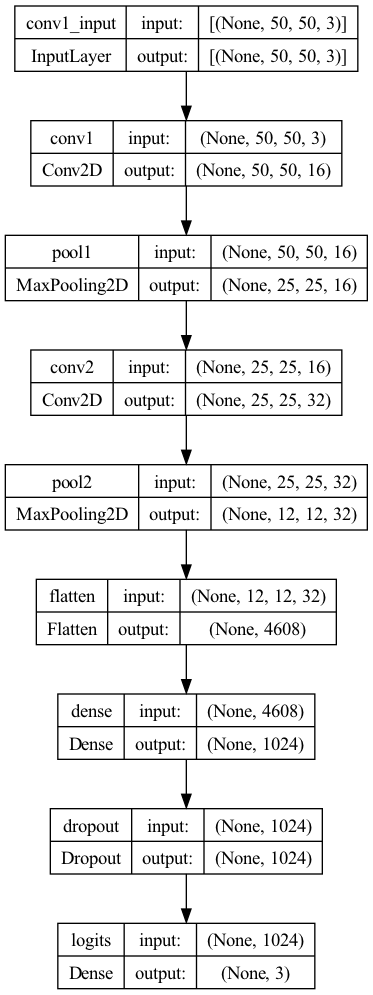

In [34]:
plot_model(model, show_shapes=True)

In [35]:
# ResNet
model_resnet_only = ResNet101(weights="imagenet", include_top=False, input_shape=(50, 50, 3))

for layer in model_resnet_only.layers:
    layer.trainable = False

# Initialize a sequential model
model_resnet = tf.keras.Sequential()
model_resnet.add(model_resnet_only)
model_resnet.add(tf.keras.layers.Flatten())
model_resnet.add(tf.keras.layers.Dense(3, activation="sigmoid"))
model_resnet.summary()

# Compiling the model
model_resnet.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=["accuracy"])

171446536/171446536 [==============================] - 11s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 2, 2048)        42658176  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 3)                 24579     
                                                                 
Total params: 42,682,755
Trainable params: 24,579
Non-trainable params: 42,658,176
_________________________________________________________________


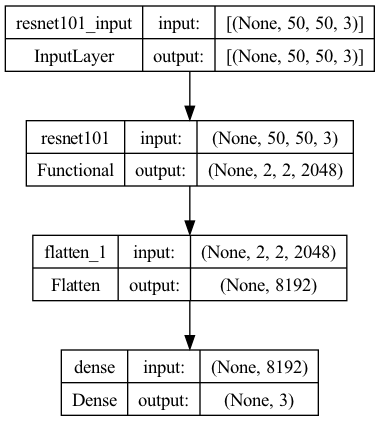

In [36]:
plot_model(model_resnet, show_shapes=True)

In [37]:
# VGG 19
vgg19_only_model = VGG19(weights="imagenet", include_top=False, input_shape=(50, 50, 3))

for layer in vgg19_only_model.layers:
    layer.trainable = False

# Initialize a sequential model
vgg19_model = tf.keras.Sequential()
vgg19_model.add(vgg19_only_model)
vgg19_model.add(tf.keras.layers.Flatten())
vgg19_model.add(tf.keras.layers.Dense(3, activation="sigmoid"))
vgg19_model.summary()

# Compiling the model
vgg19_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 20,025,923
Trainable params: 1,539
Non-trainable params: 20,024,384
_________________________________________________________________


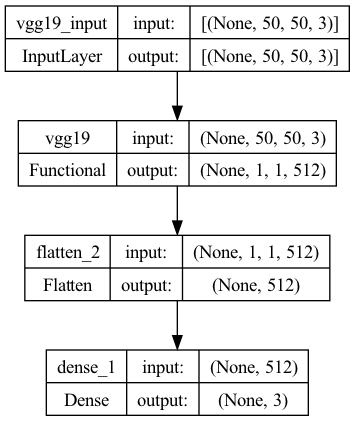

In [38]:
plot_model(vgg19_model, show_shapes=True)

In [39]:
# create callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

In [40]:
%time
history_1 = model.fit(x=train_data, validation_data=val_data, epochs=20, callbacks=[early_stopping])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 13.1 µs
Epoch 1/20
 3/92 [..............................] - ETA: 2s - loss: 1.0790 - accuracy: 0.5729 

2023-04-26 18:57:48.346442: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


92/92 [==============================] - 3s 30ms/step - loss: 0.3996 - accuracy: 0.8591 - val_loss: 0.2174 - val_accuracy: 0.9345
Epoch 2/20
92/92 [==============================] - 3s 28ms/step - loss: 0.2126 - accuracy: 0.9369 - val_loss: 0.1810 - val_accuracy: 0.9468
Epoch 3/20
92/92 [==============================] - 3s 28ms/step - loss: 0.1885 - accuracy: 0.9420 - val_loss: 0.1937 - val_accuracy: 0.9372
Epoch 4/20
92/92 [==============================] - 3s 28ms/step - loss: 0.1767 - accuracy: 0.9430 - val_loss: 0.1797 - val_accuracy: 0.9427
Epoch 5/20
92/92 [==============================] - 3s 28ms/step - loss: 0.2236 - accuracy: 0.9338 - val_loss: 0.2531 - val_accuracy: 0.9236
Epoch 6/20
92/92 [==============================] - 3s 28ms/step - loss: 0.1843 - accuracy: 0.9420 - val_loss: 0.2212 - val_accuracy: 0.9332
Epoch 7/20
92/92 [==============================] - 3s 28ms/step - loss: 0.1602 - accuracy: 0.9495 - val_loss: 0.1767 - val_accuracy: 0.9468
Epoch 8/20
92/92 [======

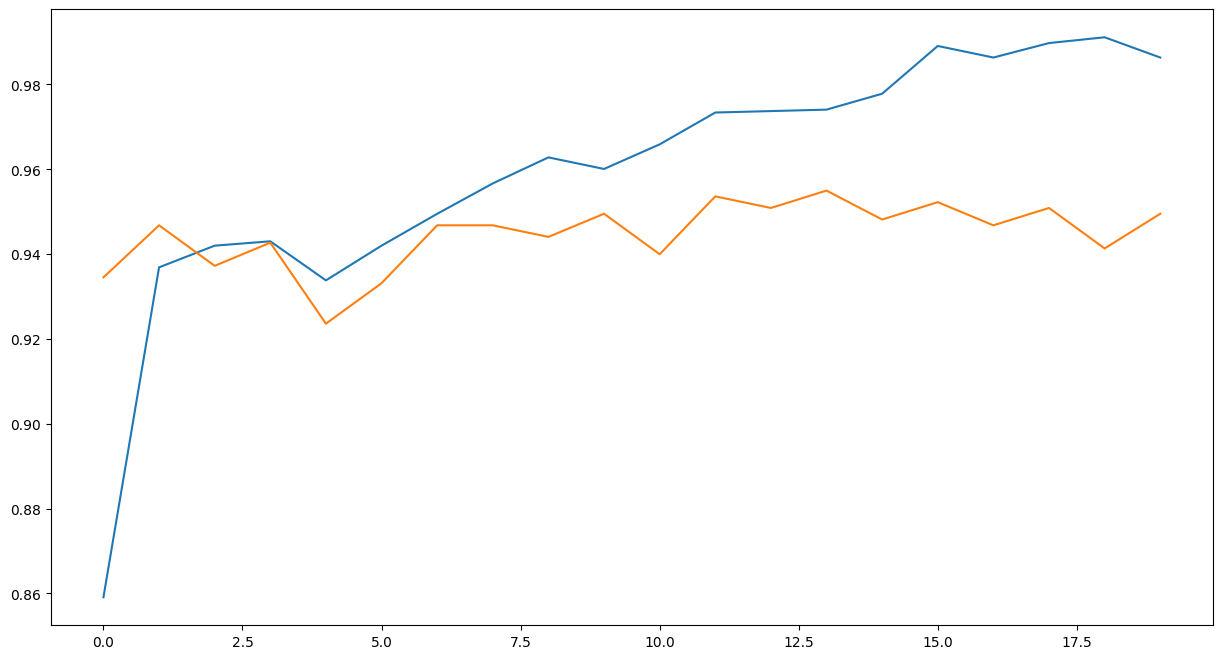

In [41]:
# Plotting Model Accuracy 
plt.figure(figsize=(15,8))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.show()

In [42]:
%time
history_2 = model_resnet.fit(x=train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 16 µs
Epoch 1/10
92/92 [==============================] - 22s 218ms/step - loss: 0.6057 - accuracy: 0.7871 - val_loss: 0.5265 - val_accuracy: 0.8226
Epoch 2/10
92/92 [==============================] - 19s 212ms/step - loss: 0.5819 - accuracy: 0.7881 - val_loss: 0.5377 - val_accuracy: 0.8226
Epoch 3/10
92/92 [==============================] - 20s 212ms/step - loss: 0.5730 - accuracy: 0.7881 - val_loss: 0.5088 - val_accuracy: 0.8226
Epoch 4/10
92/92 [==============================] - 19s 212ms/step - loss: 0.5658 - accuracy: 0.7888 - val_loss: 0.5018 - val_accuracy: 0.8226
Epoch 5/10
92/92 [==============================] - 20s 214ms/step - loss: 0.5673 - accuracy: 0.7898 - val_loss: 0.5086 - val_accuracy: 0.8213
Epoch 6/10
92/92 [==============================] - 19s 209ms/step - loss: 0.5492 - accuracy: 0.7881 - val_loss: 0.4902 - val_accuracy: 0.8226
Epoch 7/10
92/92 [==============================] - 19s 210ms/step - loss: 0.545

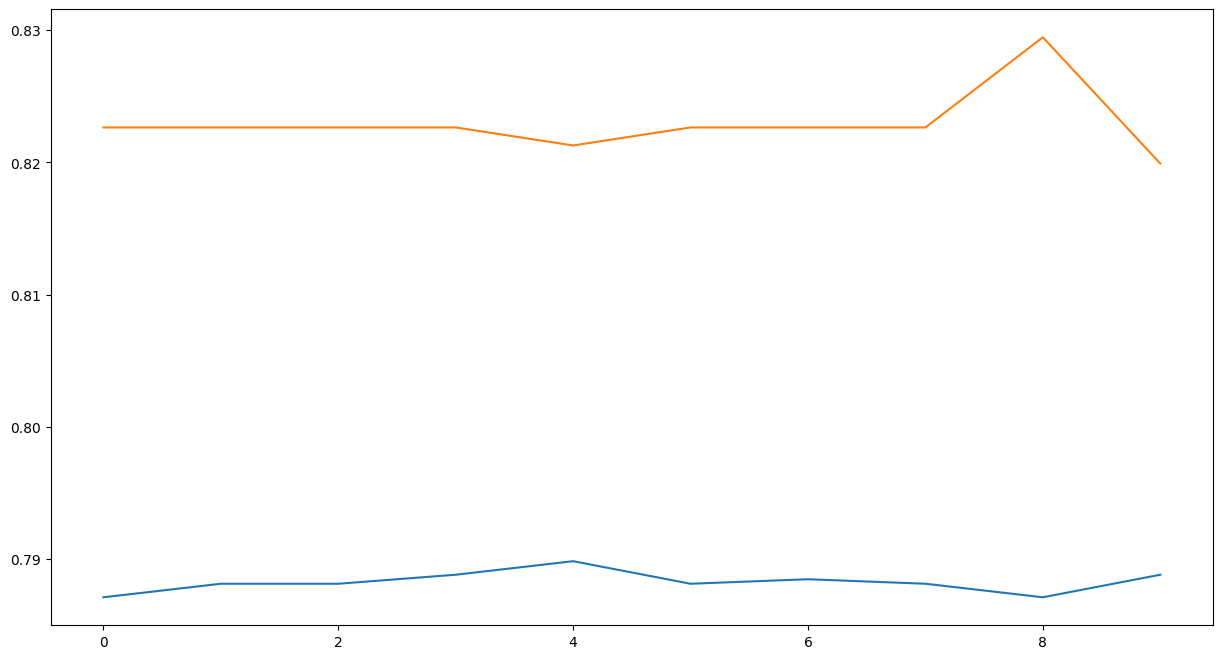

In [43]:
plt.figure(figsize=(15,8))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.show()

In [44]:
%time
history_3 = vgg19_model.fit(x=train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/10
92/92 [==============================] - 21s 228ms/step - loss: 0.5856 - accuracy: 0.7677 - val_loss: 0.4274 - val_accuracy: 0.8336
Epoch 2/10
92/92 [==============================] - 22s 234ms/step - loss: 0.4315 - accuracy: 0.8188 - val_loss: 0.3620 - val_accuracy: 0.8568
Epoch 3/10
92/92 [==============================] - 21s 233ms/step - loss: 0.3782 - accuracy: 0.8482 - val_loss: 0.3377 - val_accuracy: 0.8786
Epoch 4/10
92/92 [==============================] - 21s 232ms/step - loss: 0.3504 - accuracy: 0.8605 - val_loss: 0.3152 - val_accuracy: 0.8854
Epoch 5/10
92/92 [==============================] - 21s 229ms/step - loss: 0.3291 - accuracy: 0.8721 - val_loss: 0.2938 - val_accuracy: 0.8799
Epoch 6/10
92/92 [==============================] - 21s 227ms/step - loss: 0.3155 - accuracy: 0.8785 - val_loss: 0.2835 - val_accuracy: 0.8936
Epoch 7/10
92/92 [==============================] - 21s 229ms/step - loss:

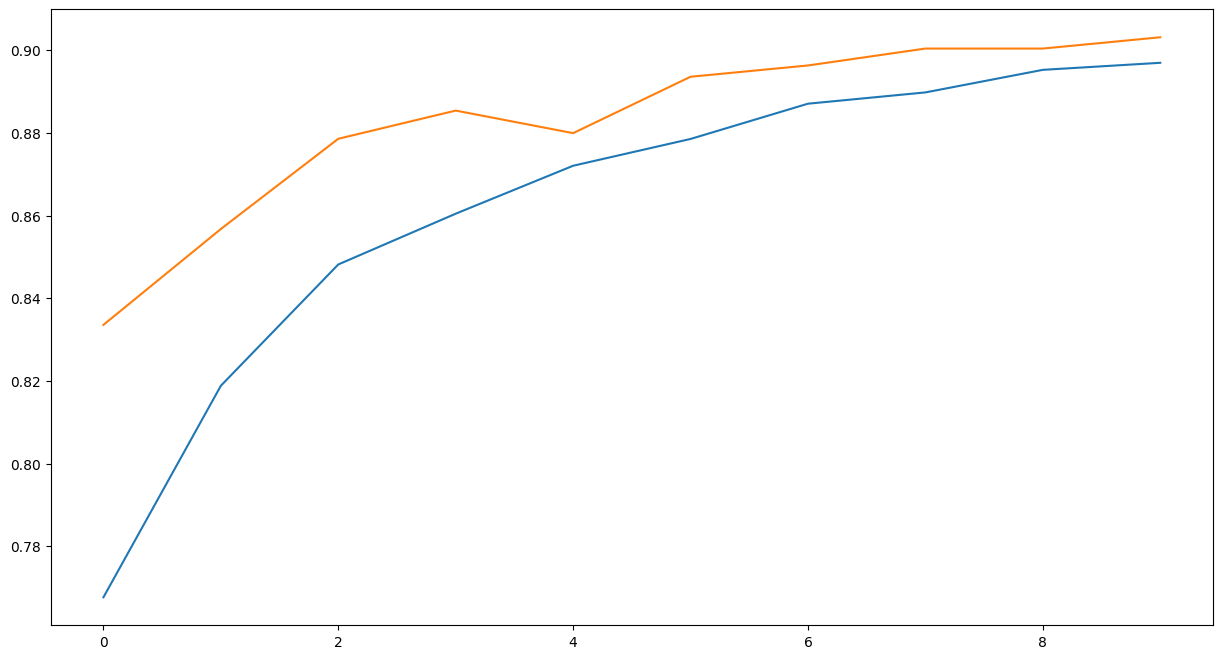

In [45]:
plt.figure(figsize=(15,8))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.show()



## Data Evaluation Simple CNN

For the next Step, I want to use the Simple CNN.

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
test_data = create_data_batch(X_test, test_data=True)
test_data.element_spec

Creating test dataset


TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None)

In [48]:
y_preds = model.predict(test_data).argmax(axis=1)

13/13 [==============================] - 0s 8ms/step


In [49]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.95      0.98      0.97       318
           2       0.93      0.86      0.89        76

    accuracy                           0.94       408
   macro avg       0.87      0.80      0.83       408
weighted avg       0.94      0.94      0.94       408



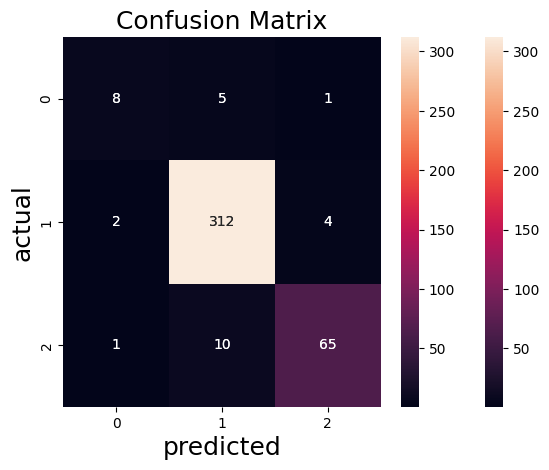

In [56]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='g')
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='g')
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()



## Data Evaluation ResNet101 Model

For the next Step, we use the Resnet Model

In [57]:
test_data = create_data_batch(X_test, test_data=True)
test_data.element_spec

Creating test dataset


TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None)

In [58]:
y_preds = model_resnet.predict(test_data).argmax(axis=1)

13/13 [==============================] - 3s 164ms/step


In [59]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.78      1.00      0.88       318
           2       0.67      0.03      0.05        76

    accuracy                           0.78       408
   macro avg       0.48      0.34      0.31       408
weighted avg       0.73      0.78      0.69       408



/Users/anis/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anis/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anis/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

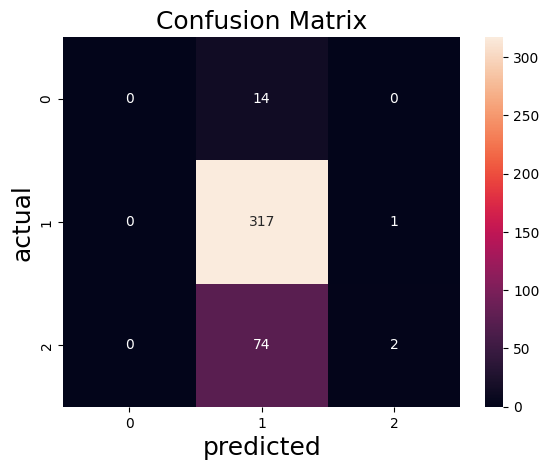

In [60]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='g')
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()



## Data Evaluation VGG19 Model

For the next Step, we use the VGG19 Model

In [61]:
test_data = create_data_batch(X_test, test_data=True)
test_data.element_spec

Creating test dataset


TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float64, name=None)

In [62]:
y_preds = vgg19_model.predict(test_data).argmax(axis=1)

13/13 [==============================] - 2s 177ms/step


In [63]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.88      0.95      0.91       318
           2       0.75      0.63      0.69        76

    accuracy                           0.86       408
   macro avg       0.54      0.53      0.53       408
weighted avg       0.83      0.86      0.84       408



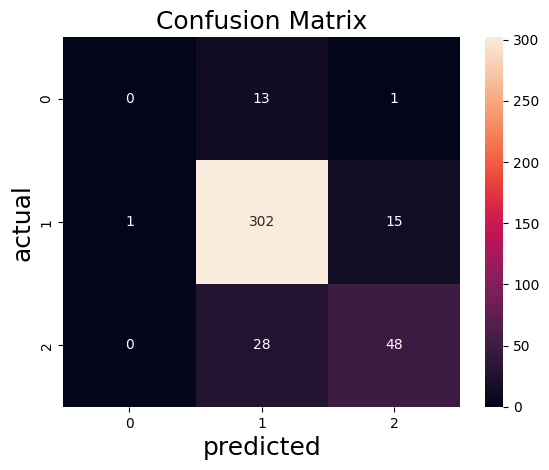

In [64]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='g')
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

## Final Test - Real World Case

We took a random image online 

In [65]:
from skimage import io

image = io.imread("http://prod-upp-image-read.ft.com/d823f77c-6de0-11ea-89df-41bea055720b")
image.shape

(1152, 2048, 3)

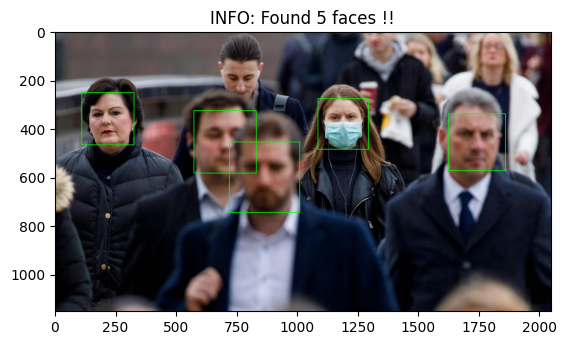

In [66]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray_img,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(50, 50)
)

cropped_image = image.copy()

plt.title(f"INFO: Found {len(faces)} faces !!")
for (x, y, w, h) in faces:
    cv2.rectangle(cropped_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(cropped_image)
plt.show()

1/1 [==============================] - 0s 22ms/step
[2]
1/1 [==============================] - 0s 9ms/step
[1]
1/1 [==============================] - 0s 9ms/step
[2]
1/1 [==============================] - 0s 9ms/step
[2]
1/1 [==============================] - 0s 9ms/step
[2]


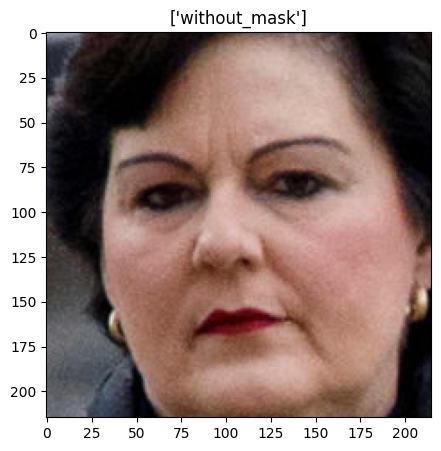

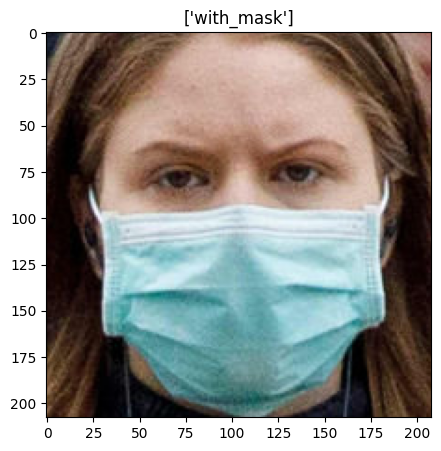

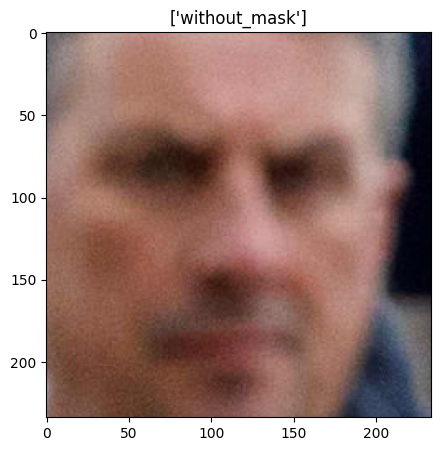

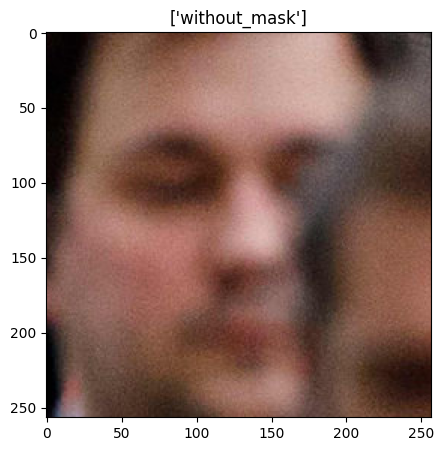

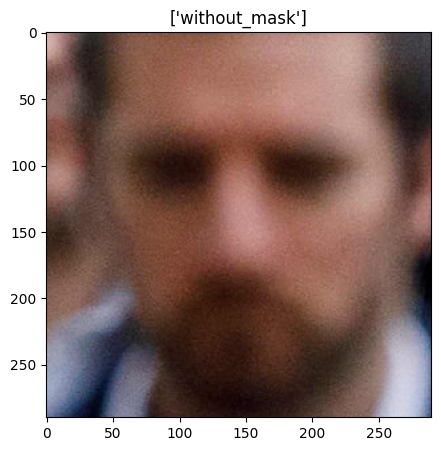

In [67]:
# Great now we extract faces and make predictions
for (x, y, w, h) in faces:
    ymin, ymax, xmin, xmax = y, y+h, x, x+w
    im_cropped = crop_image(image, xmin, ymin, xmax, ymax, is_im_arr=True)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    im_test = tf.constant([im_resized])
    y_pred = model.predict(im_test).argmax(axis=1)
    print(y_pred)
    plt.figure(figsize=(10,5))
    plt.title(le.inverse_transform(y_pred))
    plt.imshow(im_cropped)

1/1 [==============================] - 0s 38ms/step
[1]
1/1 [==============================] - 0s 32ms/step
[1]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 30ms/step
[1]


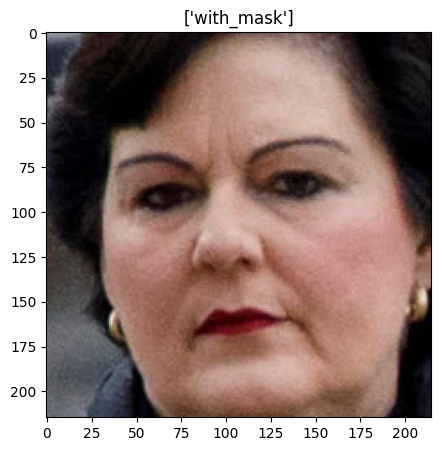

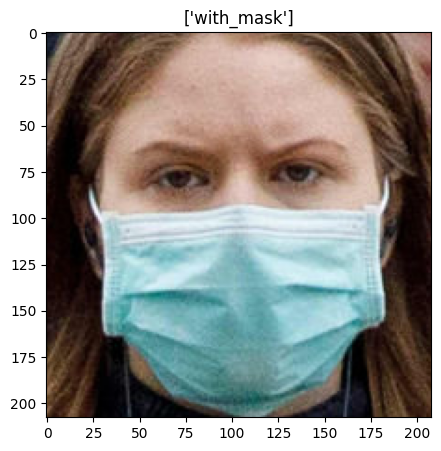

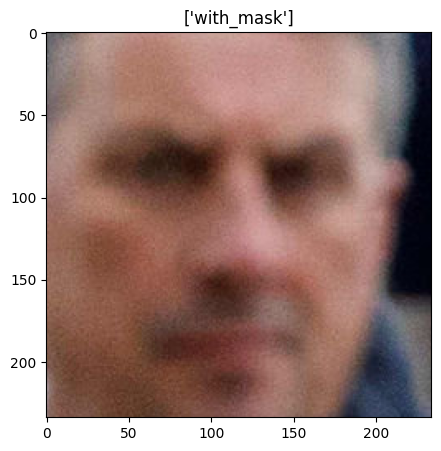

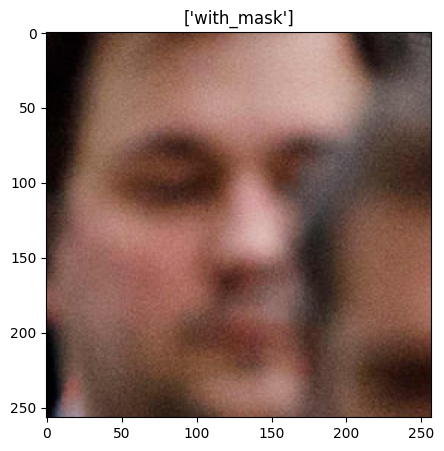

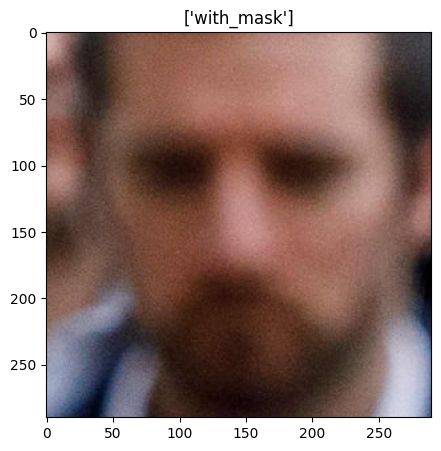

In [70]:
# Great now we extract faces and make predictions
for (x, y, w, h) in faces:
    ymin, ymax, xmin, xmax = y, y+h, x, x+w
    im_cropped = crop_image(image, xmin, ymin, xmax, ymax, is_im_arr=True)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    im_test = tf.constant([im_resized])
    y_pred = model_resnet.predict(im_test).argmax(axis=1)
    print(y_pred)
    plt.figure(figsize=(10,5))
    plt.title(le.inverse_transform(y_pred))
    plt.imshow(im_cropped)

1/1 [==============================] - 0s 36ms/step
[2]
1/1 [==============================] - 0s 20ms/step
[1]
1/1 [==============================] - 0s 21ms/step
[2]
1/1 [==============================] - 0s 21ms/step
[2]
1/1 [==============================] - 0s 23ms/step
[1]


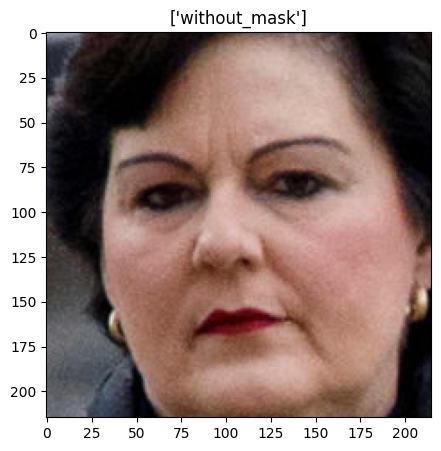

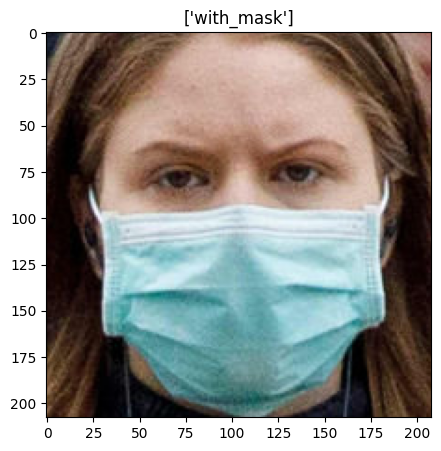

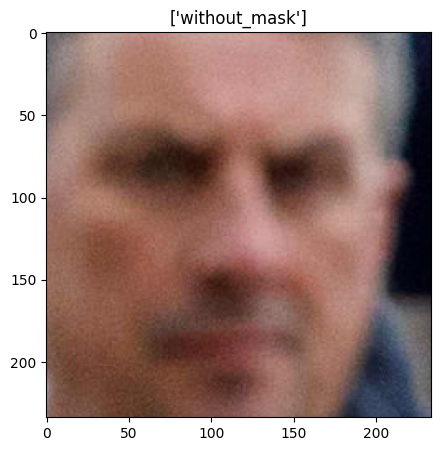

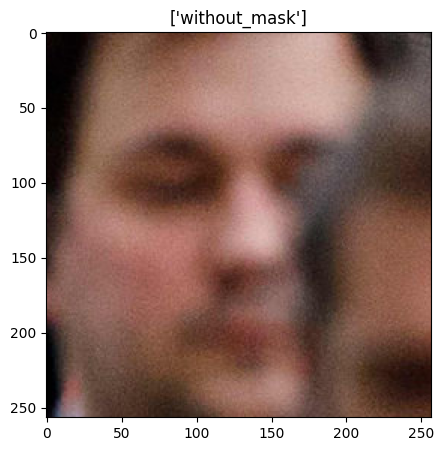

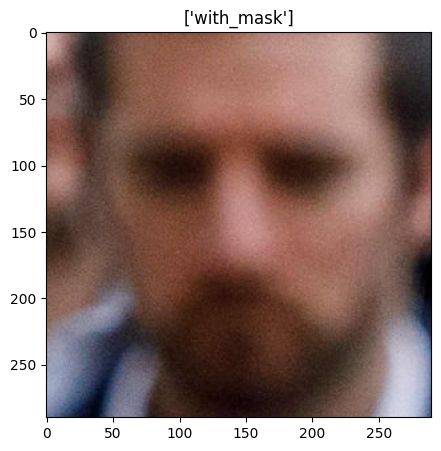

In [69]:
# Great now we extract faces and make predictions
for (x, y, w, h) in faces:
    ymin, ymax, xmin, xmax = y, y+h, x, x+w
    im_cropped = crop_image(image, xmin, ymin, xmax, ymax, is_im_arr=True)
    im_resized = cv2.resize(im_cropped, (50, 50))
    im_resized = im_resized / 255.0
    im_test = tf.constant([im_resized])
    y_pred = vgg19_model.predict(im_test).argmax(axis=1)
    print(y_pred)
    plt.figure(figsize=(10,5))
    plt.title(le.inverse_transform(y_pred))
    plt.imshow(im_cropped)